In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
img_size = (48, 48)
batch_size = 64

# Data generators with augmentation for train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Data generator for test set (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Paths to your dataset
train_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/train'
test_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test'

# Train data generator (using 80% of the data)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # This uses the 80% training portion
)

# Validation data generator (using 20% of the data)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # This uses the 20% validation portion
)

# Test data generator (no augmentation, just rescaling)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [9]:
#Build the MobileNetV2 Model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (48, 48, 3)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/tmp/ipykernel_35/931421202.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
#Train with Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_mobilenet_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=test_generator,  # using test as validation since no val folder
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.2653 - loss: 2.0958
Epoch 1: val_accuracy improved from -inf to 0.41428, saving model to best_mobilenet_model.keras
355/355 ━━━━━━━━━━━━━━━━━━━━ 205s 577ms/step - accuracy: 0.2654 - loss: 2.0953 - val_accuracy: 0.4143 - val_loss: 1.5519 - learning_rate: 1.0000e-04
Epoch 2/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3502 - loss: 1.6702
Epoch 2: val_accuracy improved from 0.41428 to 0.42358, saving model to best_mobilenet_model.keras
355/355 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accuracy: 0.3502 - loss: 1.6702 - val_accuracy: 0.4236 - val_loss: 1.5170 - learning_rate: 1.0000e-04
Epoch 3/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3761 - loss: 1.5913
Epoch 3: val_accuracy improved from 0.42358 to 0.43499, saving model to best_mobilenet_model.keras
355/355 ━━━━━━━━━━━━━━━━━━━━ 44s 125ms/step - accuracy: 0.3761 - loss: 1.5913 - val_accuracy: 0.4350 - val_loss: 1.4944 - learning_rate: 1.0000e-

In [14]:
#Fine-Tuning (Optional Boost)

base_model.trainable = True  # Unfreeze all layers

model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint]
)



Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3621 - loss: 1.6656
Epoch 1: val_accuracy did not improve from 0.46809
355/355 ━━━━━━━━━━━━━━━━━━━━ 123s 201ms/step - accuracy: 0.3621 - loss: 1.6656 - val_accuracy: 0.4480 - val_loss: 1.4585 - learning_rate: 1.0000e-05
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3868 - loss: 1.6015
Epoch 2: val_accuracy did not improve from 0.46809
355/355 ━━━━━━━━━━━━━━━━━━━━ 50s 140ms/step - accuracy: 0.3868 - loss: 1.6015 - val_accuracy: 0.4387 - val_loss: 1.4862 - learning_rate: 1.0000e-05
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4100 - loss: 1.5460
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 3: val_accuracy did not improve from 0.46809
355/355 ━━━━━━━━━━━━━━━━━━━━ 51s 142ms/step - accuracy: 0.4100 - loss: 1.5460 - val_accuracy: 0.4292 - val_loss: 1.4981 - learning_rate: 1.0000e-05
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accur

111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.4752 - loss: 1.4348
Test Accuracy: 47.25%
89/89 ━━━━━━━━━━━━━━━━━━━━ 49s 547ms/step - accuracy: 0.4604 - loss: 1.4470
Validation Accuracy: 46.79%
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4676 - loss: 1.4217
Test Accuracy: 47.25%


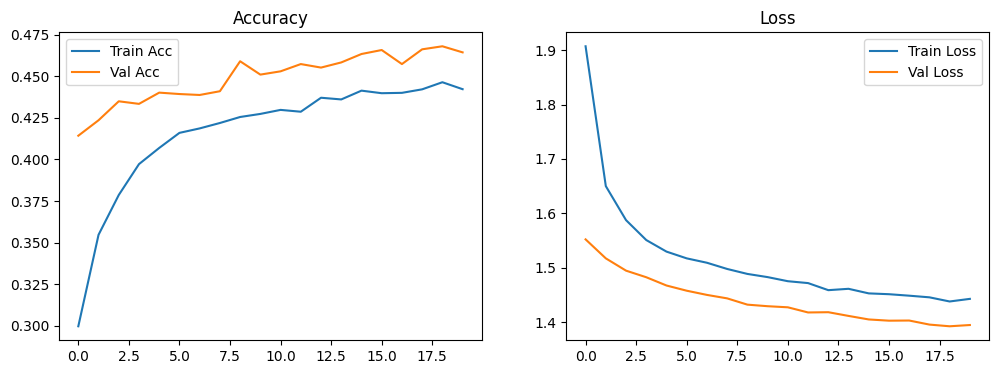

In [15]:
#Evaluate and Visualize

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Validation accuracy
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


# Plot Accuracy & Loss
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [16]:
#Test with a Sample Image

import cv2
import numpy as np

def predict_emotion(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print("❌ Error: Cannot load image.")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[np.argmax(prediction)]

    print(f"✅ Predicted Emotion: {predicted_label}")

    plt.imshow(img[0])
    plt.title(predicted_label)
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Predicted Emotion: happiness


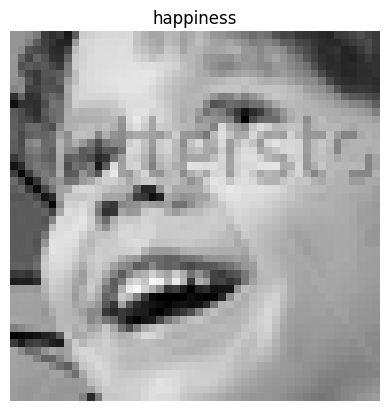

In [17]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/happiness/fer0028754.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
✅ Predicted Emotion: happiness


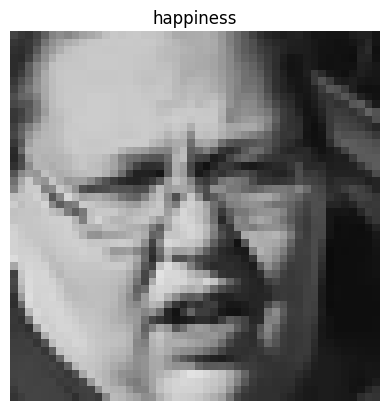

In [18]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028733.png')


In [19]:
# Save the entire model
model.save("emotion_model_mobilenet_v2.h5")  # or .keras
